In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
import os
import sys
import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

In [11]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [12]:
DATA_DIRS_LIST = glob.glob("../data/*")
DATA_DIRS_LIST

['../data/german_equity', '../data/dax-euro', '../data/simulated']

In [13]:
glob.glob(os.path.join(DATA_DIRS_LIST[0], "*"))

['../data/german_equity/xFGBS',
 '../data/german_equity/xFGBM',
 '../data/german_equity/xFGBL',
 '../data/german_equity/README']

In [14]:
glob.glob(os.path.join(DATA_DIRS_LIST[1], "*"))

['../data/dax-euro/xFSXE', '../data/dax-euro/README', '../data/dax-euro/xFDAX']

## Low-tick asset: DAX

Side:
* $-1$: ask
* $1$: bid

Type:
* $-1$: limit
* $0$: cancel
* $1$: trade

In [15]:
DAX_DATA_PATH = "../data/dax-euro/xFDAX"
DAX_DATA_LIST = glob.glob(os.path.join(DAX_DATA_PATH, "*"))
DAX_DATA_LIST.sort()

In [16]:
FILES = DAX_DATA_LIST[:8]
print(FILES)

['../data/dax-euro/xFDAX/xFDAX_20130701.csv', '../data/dax-euro/xFDAX/xFDAX_20130702.csv', '../data/dax-euro/xFDAX/xFDAX_20130703.csv', '../data/dax-euro/xFDAX/xFDAX_20130704.csv', '../data/dax-euro/xFDAX/xFDAX_20130705.csv', '../data/dax-euro/xFDAX/xFDAX_20130708.csv', '../data/dax-euro/xFDAX/xFDAX_20130709.csv', '../data/dax-euro/xFDAX/xFDAX_20130710.csv']


In [17]:
frames_ = []
indices_ = [0]
for file in FILES:
    print(file)
    df_ = pd.read_csv(file)
    frames_.append(df_)
    indices_.append(indices_[-1] + len(df_))
    
df = pd.concat(frames_, ignore_index=True)

df['MidPrice'] = 0.5*(df.AskPriceAfter + df.BidPriceAfter)

df['MidPriceVar'] = df.MidPrice.diff()

../data/dax-euro/xFDAX/xFDAX_20130701.csv
../data/dax-euro/xFDAX/xFDAX_20130702.csv
../data/dax-euro/xFDAX/xFDAX_20130703.csv
../data/dax-euro/xFDAX/xFDAX_20130704.csv
../data/dax-euro/xFDAX/xFDAX_20130705.csv
../data/dax-euro/xFDAX/xFDAX_20130708.csv
../data/dax-euro/xFDAX/xFDAX_20130709.csv
../data/dax-euro/xFDAX/xFDAX_20130710.csv


In [18]:
df

,Date,Time,Volume,OrderType,Side,AskPriceAfter,AskQtyAfter,AskSplitAfter,BidPriceAfter,BidQtyAfter,BidSplitAfter,MidPrice,MidPriceVar
0,20130701,28806.446250,13,1,1,7956.0,1,1,7955.5,30,2,7955.75,NaN
1,20130701,28806.584304,4,1,1,7956.0,1,1,7955.5,34,3,7955.75,0.00
2,20130701,28806.601666,1,0,-1,7957.0,5,2,7955.5,34,3,7956.25,0.50
3,20130701,28806.603896,4,1,1,7957.0,5,2,7955.5,38,4,7956.25,0.00
4,20130701,28806.752690,1,1,1,7957.0,5,2,7956.5,1,1,7956.75,0.50
5,20130701,28806.891006,1,1,-1,7957.0,6,3,7956.5,1,1,7956.75,0.00
6,20130701,28806.892582,1,1,-1,7957.0,7,4,7956.5,1,1,7956.75,0.00
7,20130701,28807.066006,1,1,1,7957.0,7,4,7956.5,2,2,7956.75,0.00
8,20130701,28807.096734,1,0,-1,7957.0,6,3,7956.5,2,2,7956.75,0.00
9,20130701,28807.097236,3,0,-1,7957.0,3,3,7956.5,2,2,7956.75,0.00


### Model

* 0: midprice goes down $N_t^1$
* 1: midprice goes up $N_t^2$

# Influence of ask and bid

In [19]:
from torch import nn

from models import HawkesDecayRNN
from train_functions import train_decayrnn

In [20]:
num_of_splits = 60

In [22]:
process_dim = 2

In [23]:
split_times_list = []
split_types_list = []
seq_lengths = []
for file in FILES:
    df = pd.read_csv(file)
    day_stamp = df.Date.values[0]
    print("Day", day_stamp)
    df['MidPrice'] = 0.5*(df.AskPriceAfter + df.BidPriceAfter)
    df['MidPriceVar'] = df.MidPrice.diff()
    df_filtered: pd.DataFrame = df[df.MidPriceVar != 0]
    df_filtered['MidPriceChangeType'] = (df.MidPriceVar > 0).astype(int)
    # Arrange our data
    evt_times = df_filtered.Time.values
    evt_types = df_filtered.MidPriceChangeType.values

    sttl_ = np.array_split(evt_times, num_of_splits)
    stpl_ = np.array_split(evt_types, num_of_splits)
    seq_lengths += [len(e) for e in sttl_]
    split_times_list += [torch.from_numpy(e) for e in sttl_]
    split_types_list += [torch.from_numpy(e) for e in stpl_]
seq_lengths = torch.LongTensor(seq_lengths) - 1
seq_times = nn.utils.rnn.pad_sequence(split_times_list, batch_first=True).to(torch.float32)
seq_types = nn.utils.rnn.pad_sequence(split_types_list, batch_first=True, padding_value=process_dim)
print(seq_times.shape)

Day 20130701


/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


Day 20130702
Day 20130703
Day 20130704
Day 20130705
Day 20130708
Day 20130709
Day 20130710
torch.Size([480, 1995])


In [24]:
from torch.nn import functional as F

# Evaluation

## RNN model

In [25]:
process_dim = 2
hidden_size = 128

In [26]:
rnn_model = HawkesDecayRNN(process_dim, hidden_size)

In [27]:
MODEL_FILES = glob.glob("../saved_models/HawkesDecay*")
MODEL_FILES.sort(reverse=True)
MODEL_FILES

['../saved_models/HawkesDecayRNN-2d_hidden128-20181210-234746.pth',
 '../saved_models/HawkesDecayRNN-2d_hidden128-20181210-013110.pth',
 '../saved_models/HawkesDecayRNN-2d_hidden128-20181209-212603.pth',
 '../saved_models/HawkesDecayRNN-2d_hidden128-20181209-153942.pth']

In [28]:
_model_file = MODEL_FILES[0]
print(_model_file)
rnn_model.load_state_dict(torch.load(MODEL_FILES[0], map_location={"cuda:0": "cpu"}))

../saved_models/HawkesDecayRNN-2d_hidden128-20181210-234746.pth


In [29]:
from utils import evaluation

In [30]:
dataset_size = seq_times.shape[0]
print("Dataset size:", dataset_size)

train_size = 420
test_size = 120

Dataset size: 480


last event: time 39947.578 type 1.000
next event: time 39947.578 type 1.000, in 0.000
sum of density: tensor(0.8214)
type probabilities: tensor([0.3993, 0.4028])


((tensor(0.0984), tensor(0.), tensor(0.0097), tensor(1), tensor(1)),
 <Figure size 1000x400 with 2 Axes>)

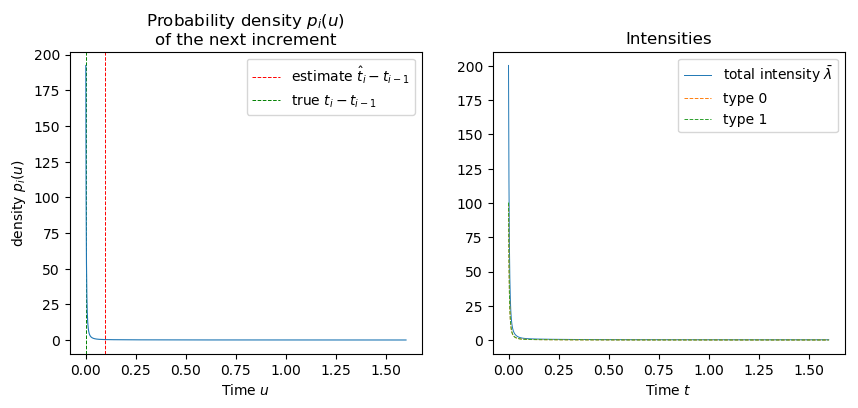

In [34]:
index_ = torch.randint(0, dataset_size, (1,)).int().item()

rnn_model.read_predict(seq_times[index_], seq_types[index_], seq_lengths[index_],
                   hmax=1.6, n_samples=8000, plot=True, print_info=True)

In [35]:
beg_index_ = train_size
test_data = (seq_times[train_size:], seq_types[train_size:], seq_lengths[train_size])
test_data[0].shape

torch.Size([60, 1995])

In [69]:
incr_estimates, incr_errors, types_real, types_estimates = evaluation.predict_test(
    model, *test_data,
    hmax=0.7, use_jupyter=True)

In [70]:
avg_rmse = np.sqrt(np.mean(incr_errors), dtype=np.float64)
print("rmse", avg_rmse)

mse_var = np.var(incr_errors, dtype=np.float64)
print("mse var", mse_var)

delta_meth_stderr = np.sqrt(1 / test_size * mse_var / (4 * avg_rmse))
print("rmse var", delta_meth_stderr)

rmse 0.43237952599606266
mse var 2.6977105307954954
rmse var 0.039494363353466524


In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [72]:
types_predict_score = accuracy_score(types_real, types_estimates)
print("Type prediction score:", types_predict_score)

print("Confusion matrix:\n", confusion_matrix(types_real, types_estimates))

Type prediction score: 0.476
Confusion matrix:
 [[  0 524]
 [  0 476]]


### Sequence generation

In [36]:
from models.decayrnn import HawkesRNNGen

In [39]:
generator = HawkesRNNGen(rnn_model, record_intensity=False)

Process model dim:	2	Hidden units:	128


In [72]:
_.savefig('../results/intensity_HawkesDecayRNN_2d_hidden128_Financial_20181210-235709.pdf')

no. of events: 18
0: type 0
1: type 1


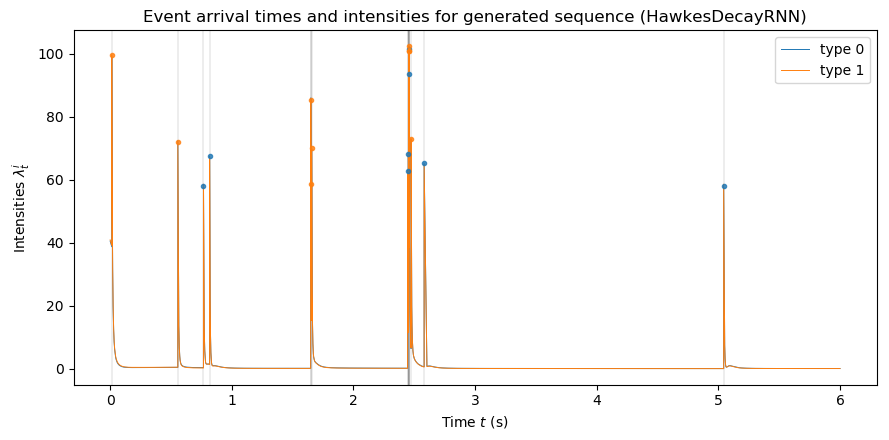

In [82]:
tmax_simu = 6
generator.generate_sequence(tmax_simu, record_intensity=True)
_ = generator.plot_events_and_intensity()

Modèle de prix:
$$
    P_t = N_t^1 - N_t^2
$$

In [83]:
t_vals = np.linspace(0, tmax_simu, num=1000)

In [117]:
def price(t, generator):
    x = np.asarray(generator.event_times[1:]) <= t
    evt_types = np.asarray(generator.event_types[1:])
    print(x.shape)
    typ0 = x[:, evt_types == 0]
    typ1 = x[:, evt_types == 1]
    nt = np.sum(x, axis=1)
    nt1 = np.sum(typ0, axis=1)
    nt2 = np.sum(typ1, axis=1)
    return nt, nt1, nt2

(1000, 1)


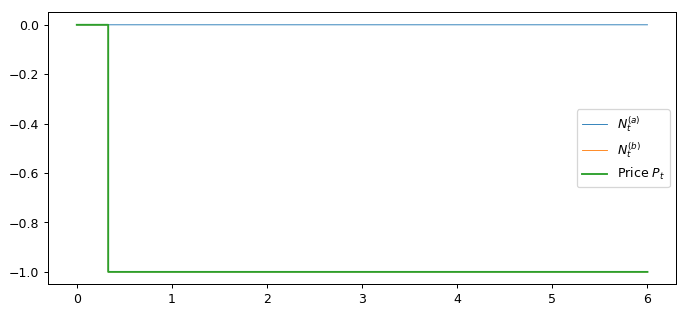

In [118]:
nt, nta, ntb = price(t_vals[:, None], lstm_gen)
plt.figure(figsize=(9,4), dpi=90)
step_opts = dict(
    linewidth=.7)
plt.step(t_vals, nta, **step_opts, label="$N_t^{(a)}$")
plt.step(t_vals, -ntb, **step_opts, label="$N_t^{(b)}$")
pt = nta - ntb
plt.step(t_vals, pt, label="Price $P_t$")
plt.legend()
plt.savefig('../results/DecayRNN-learnedpricetraj.pdf')

## LSTM model

In [85]:
from models.ctlstm import HawkesLSTM, HawkesLSTMGen

In [86]:
lstm_model = HawkesLSTM(process_dim, hidden_size)

In [87]:
MODEL_FILES = glob.glob("../saved_models/HawkesLSTM*")
MODEL_FILES.sort(reverse=True)
MODEL_FILES

['../saved_models/HawkesLSTM-2d_hidden128-20181210-235711.pth',
 '../saved_models/HawkesLSTM-2d_hidden128-20181209-214506.pth',
 '../saved_models/HawkesLSTM-2d_hidden128-20181209-173255.pth',
 '../saved_models/HawkesLSTM-2d_hidden128-20181209-154233.pth',
 '../saved_models/HawkesLSTM-2d-sumexp_hidden128-20181210-004752.pth']

In [88]:
_model_file = MODEL_FILES[0]
print(_model_file)
lstm_model.load_state_dict(torch.load(MODEL_FILES[0], map_location={"cuda:0": "cpu"}))

../saved_models/HawkesLSTM-2d_hidden128-20181210-235711.pth


In [91]:
load_file_ts = "-".join(os.path.splitext(_model_file)[0].split('-')[-2:])
load_file_ts

'20181210-235711'

In [92]:
lstm_gen = HawkesLSTMGen(lstm_model, record_intensity=False)

Process model dim:	2	Hidden units:	128


no. of events: 2
0: type 0
1: type 1


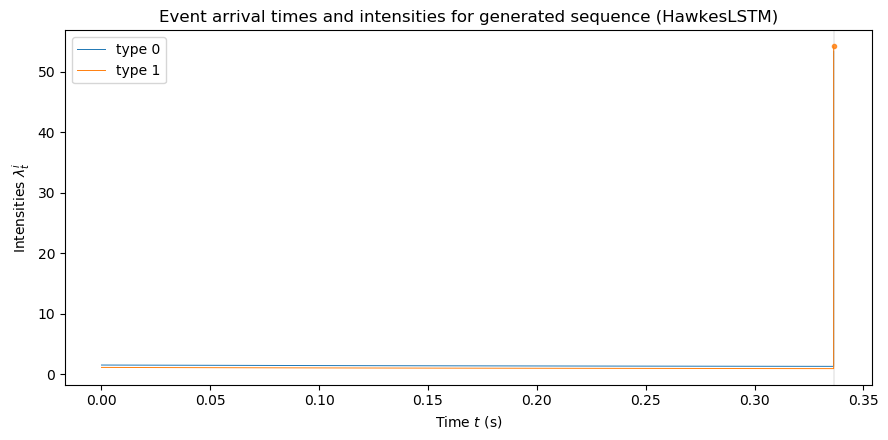

In [109]:
lstm_gen.generate_sequence(tmax_simu, record_intensity=True)
fig = lstm_gen.plot_events_and_intensity()

In [119]:
fig.savefig('../results/intensity_HawkesLSTM_2d_hidden128_Financial_{}.pdf'.format(load_file_ts))

In [113]:
t_vals = np.linspace(0, tmax_simu, num=1000)

(1000, 1)


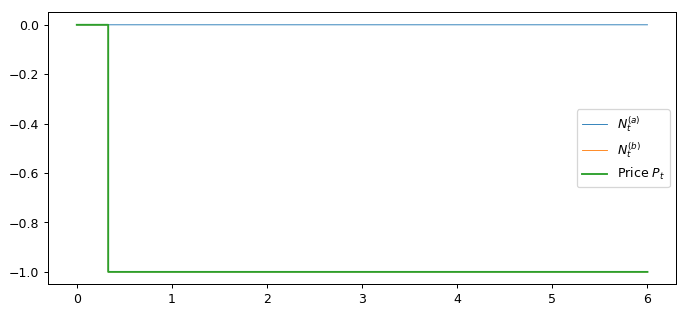

In [115]:
nt, nta, ntb = price(t_vals[:, None], lstm_gen)
plt.figure(figsize=(9,4), dpi=90)
step_opts = dict(
    linewidth=.7)
plt.step(t_vals, nta, **step_opts, label="$N_t^{(a)}$")
plt.step(t_vals, -ntb, **step_opts, label="$N_t^{(b)}$")
pt = nta - ntb
plt.step(t_vals, pt, label="Price $P_t$")
plt.legend()
plt.savefig('../results/LSTM-learnedpricetraj.pdf')